In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm

from scipy import stats
from scipy.special import expit as logistic

In [2]:
%config InlineBackend.figure_format = 'retina'
%load_ext watermark
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")
plt.style.use("dark_background")

%watermark -n -u -v -iv -w

Last updated: Tue Aug 23 2022

Python implementation: CPython
Python version       : 3.9.13
IPython version      : 8.4.0

arviz     : 0.12.1
scipy     : 1.8.1
sys       : 3.9.13 | packaged by conda-forge | (main, May 27 2022, 17:00:33) 
[Clang 13.0.1 ]
matplotlib: 3.5.2
numpy     : 1.22.4
pymc      : 4.1.3
pandas    : 1.4.3

Watermark: 2.3.1



14.1 simulated cafes

In [3]:
a = 3.5 ## intercept = mean morning wait time
b = -1.0 ## slope = diff btw morning and afternoon
sA = 1 ## sd intercept
sB = 0.5 ## sd slope
r = -0.7 ## correlation slope and intercept

In [28]:
Mu = [a, b]
svec = [sA, sB]
Rho = np.array([[1,r],[r,1]]) ## correlation matrix
Sigma = np.diag(svec) @ Rho @ np.diag(svec) ## var-covar matrix

In [181]:
nCafes = 20
intercepts_slopes = np.random.multivariate_normal(Mu, Sigma, nCafes)

In [137]:
x0 = np.random.multivariate_normal(Mu, Sigma, 100000)
x1 = stats.multivariate_normal.pdf(x0,Mu,Sigma)

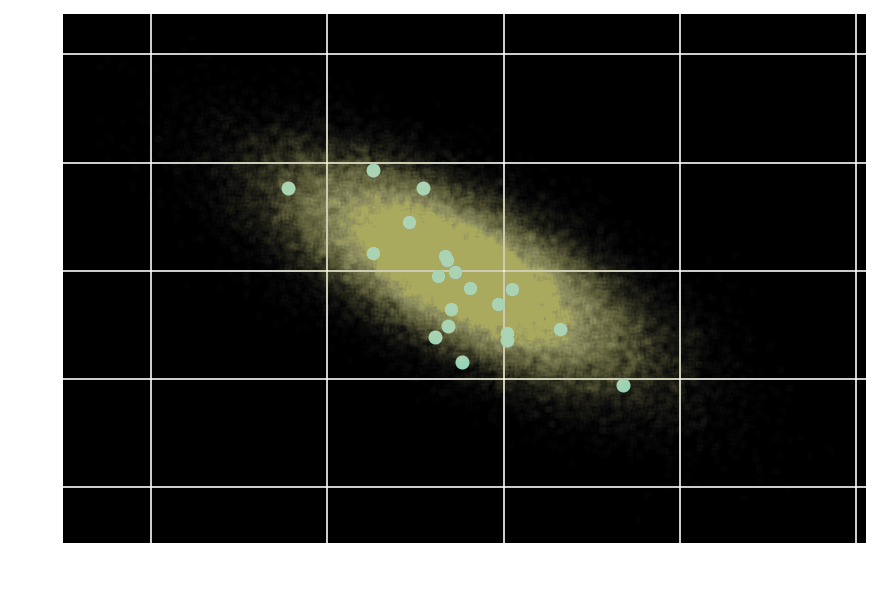

In [176]:
_, ax = plt.subplots()
ax.scatter(intercepts_slopes[:,0],intercepts_slopes[:,1])
ax.scatter(x0[:,0], x0[:,1], marker='.', alpha=0.01) #0.05*logistic(-10*x1))

In [192]:
nVisits = 10
afternoon = np.tile([0,1], nVisits * nCafes // 2)
cafeId = np.repeat(np.arange(nCafes), nVisits)
muWait = intercepts_slopes[cafeId,0] + intercepts_slopes[cafeId,1] * afternoon
sWait = 0.5

In [199]:
obsWait = np.random.normal(muWait, sWait, nVisits * nCafes)
d = pd.DataFrame({'cafe': cafeId, 'afternoon': afternoon, 'wait': obsWait})
d.head()

,cafe,afternoon,wait
0,0,0,2.867103
1,0,1,1.918657
2,0,0,2.725878
3,0,1,1.059267
4,0,0,2.910544


<AxesSubplot:>

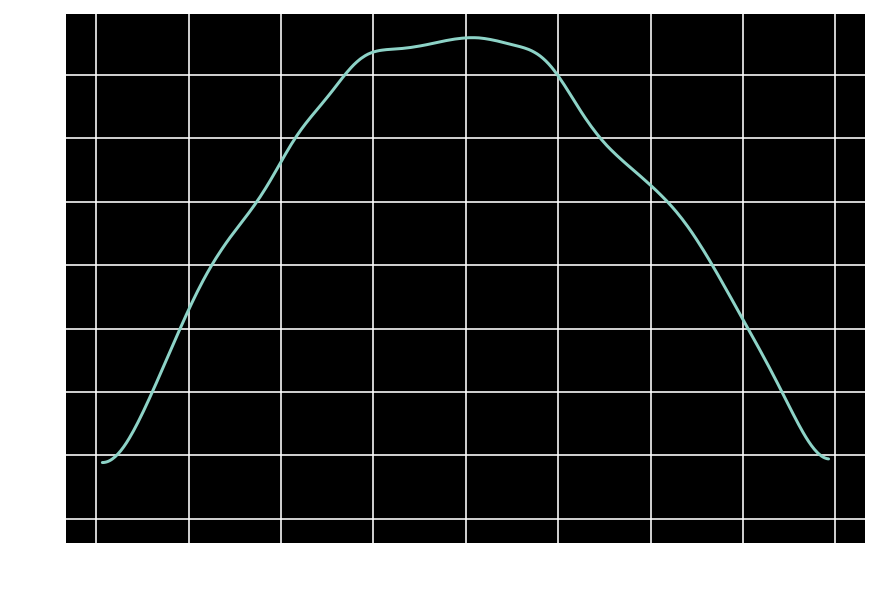

In [178]:
## LKJ distribution is used to generate correlation coefficients
##   when n=2, generates a single coefficient (for a 2x2 correlation matrix)
x = pm.LKJCorr.dist(n=2, eta=2, size=10000)
az.plot_kde(x.eval())

In [180]:
## when n > 2, generates coeffiecients for an n x n correlation matrix
x = pm.LKJCorr.dist(n=4, eta=2, size=3)
print(x.eval())

[[ 0.55213719  0.26643793 -0.41241268 -0.02237414 -0.23450932 -0.11820256]
 [-0.64215074  0.19023825  0.2456991  -0.24609711 -0.69304197  0.30734967]
 [ 0.74002394 -0.54902389  0.01795225 -0.64501972 -0.39414168 -0.12306822]]


In [203]:
with pm.Model() as m1:
    ##pm.LKJCholeskyCov produces chol decomp which can be fed directly to pm.MvNormal
    ##  (pm.LKJCorr only generates rhos, and then we'd have to do matrix algebra)
    ##   note .dist()
    chol, _, _ = pm.LKJCholeskyCov("chol", n=2, eta=2, sd_dist=pm.Exponential.dist(1.0))
    mu_ab = pm.Normal("mu_ab", [5.0, -1.0], [2.0, 0.5], shape=2)
    ## note shape
    ab = pm.MvNormal("ab", mu=mu_ab, chol=chol, shape=(nCafes,2))
    cafeId = pm.MutableData("cafe_id", d['cafe'])
    afternoon = pm.MutableData("afternoon", d['afternoon'])
    ## likelihood
    muWait = pm.Deterministic("mu_wait", ab[cafeId,0] + ab[cafeId,1] * afternoon)
    sWait = pm.Exponential("sigma_wait", 1)
    obsWait = pm.Normal("wait", muWait, sWait, observed=d['wait'])
    trace1 = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [chol, mu_ab, ab, sigma_wait]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 33 seconds.


In [204]:
trace1

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data
	> constant_data

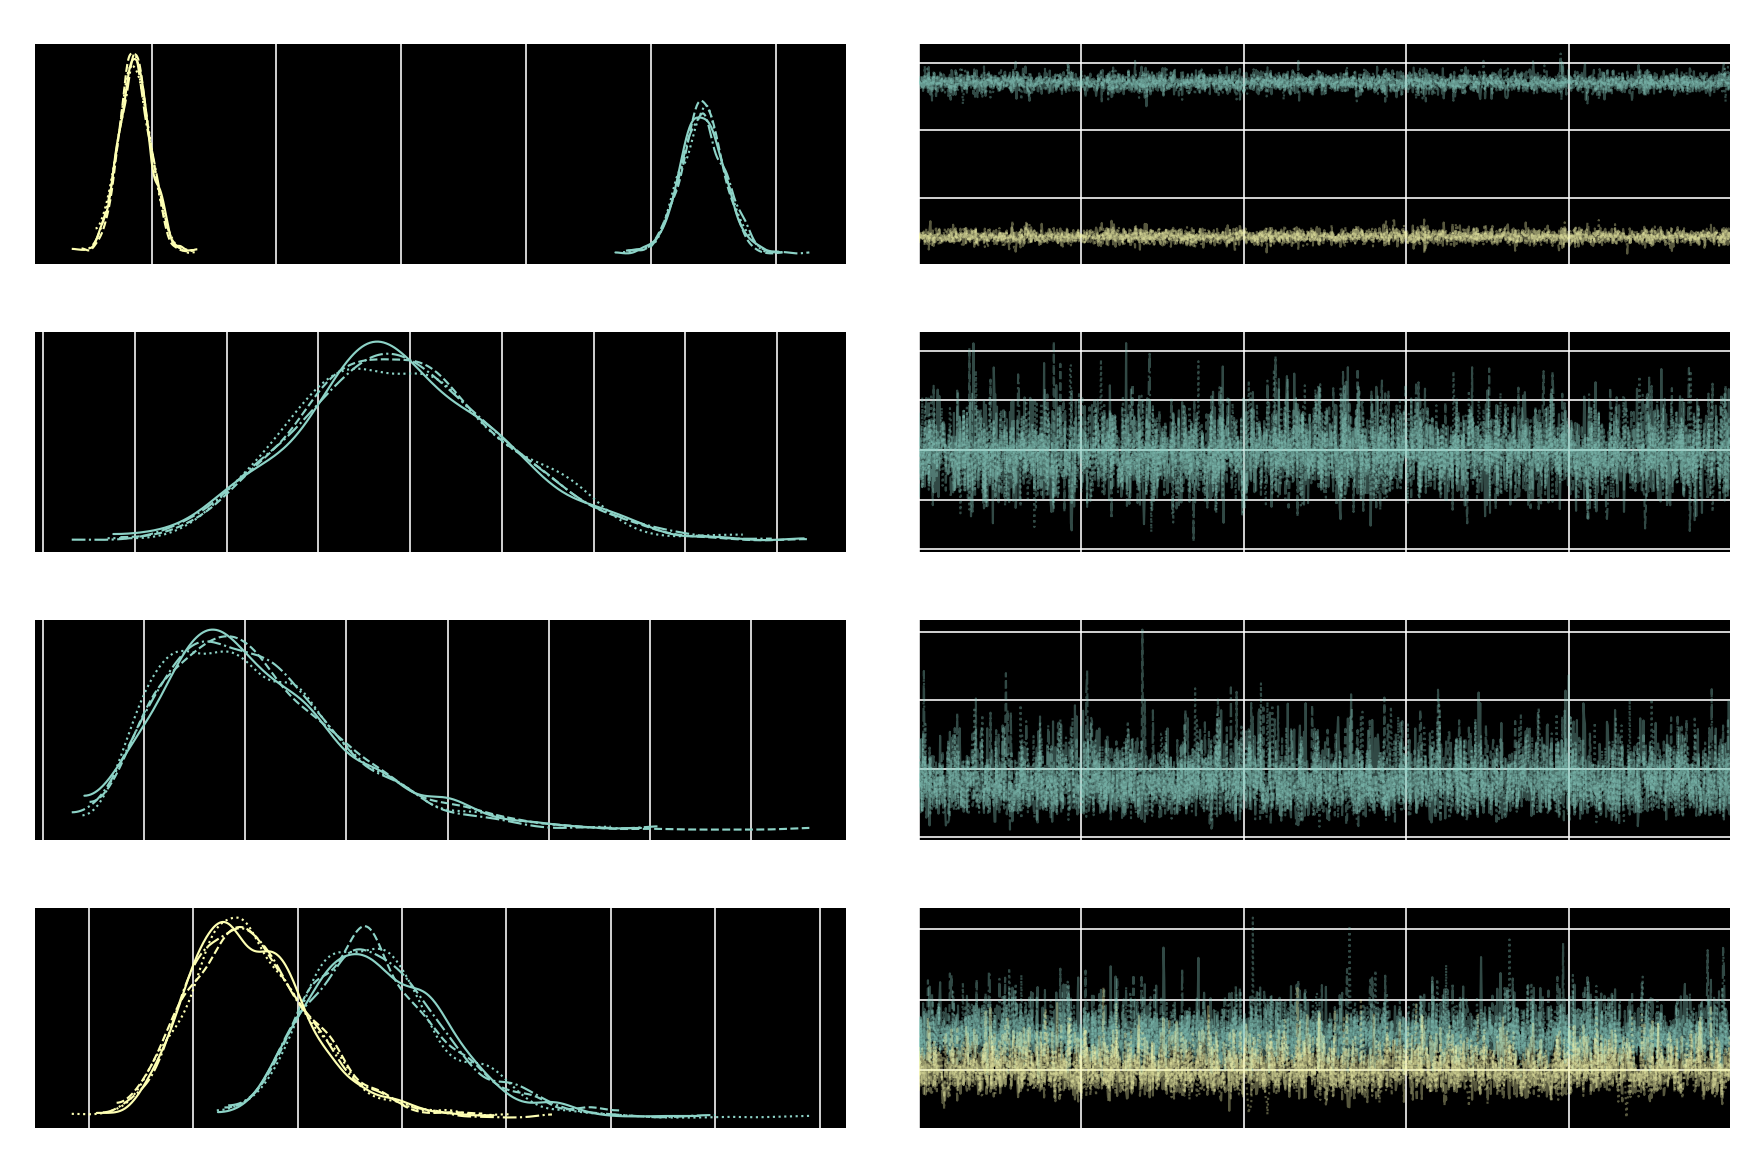

In [222]:
az.plot_trace(trace1, var_names=['mu_ab','sigma_wait','chol_corr','chol_stds'],
coords={'chol_corr_dim_0':1, 'chol_corr_dim_1':0});

In [225]:
az.summary(trace1,var_names=['~ab','~mu_wait'])

/Users/sasha/miniforge3/lib/python3.9/site-packages/arviz/stats/diagnostics.py:586: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_ab[0],3.416,0.178,3.079,3.742,0.003,0.002,4920.0,3065.0,1.0
mu_ab[1],-1.138,0.131,-1.386,-0.898,0.002,0.001,4233.0,3160.0,1.0
chol[0],0.758,0.135,0.538,1.022,0.002,0.001,5009.0,3368.0,1.0
chol[1],-0.301,0.127,-0.533,-0.059,0.002,0.002,3465.0,3278.0,1.0
chol[2],0.399,0.100,0.232,0.597,0.002,0.001,2789.0,2260.0,1.0
sigma_wait,0.497,0.028,0.449,0.553,0.000,0.000,4737.0,3360.0,1.0
"chol_corr[0, 0]",1.000,0.000,1.000,1.000,0.000,0.000,4000.0,4000.0,NaN
"chol_corr[0, 1]",-0.580,0.180,-0.875,-0.243,0.003,0.002,3980.0,3236.0,1.0
"chol_corr[1, 0]",-0.580,0.180,-0.875,-0.243,0.003,0.002,3980.0,3236.0,1.0
"chol_corr[1, 1]",1.000,0.000,1.000,1.000,0.000,0.000,3695.0,4000.0,1.0


In [228]:
az.summary(trace1, var_names=['mu_ab','sigma_wait','chol_corr','chol_stds'],
coords={'chol_corr_dim_0':1, 'chol_corr_dim_1':0})

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_ab[0],3.416,0.178,3.079,3.742,0.003,0.002,4920.0,3065.0,1.0
mu_ab[1],-1.138,0.131,-1.386,-0.898,0.002,0.001,4233.0,3160.0,1.0
sigma_wait,0.497,0.028,0.449,0.553,0.000,0.000,4737.0,3360.0,1.0
chol_corr,-0.580,0.180,-0.875,-0.243,0.003,0.002,3980.0,3236.0,1.0
chol_stds[0],0.758,0.135,0.538,1.022,0.002,0.001,5009.0,3368.0,1.0
chol_stds[1],0.512,0.117,0.291,0.720,0.002,0.002,2554.0,2677.0,1.0


<AxesSubplot:>

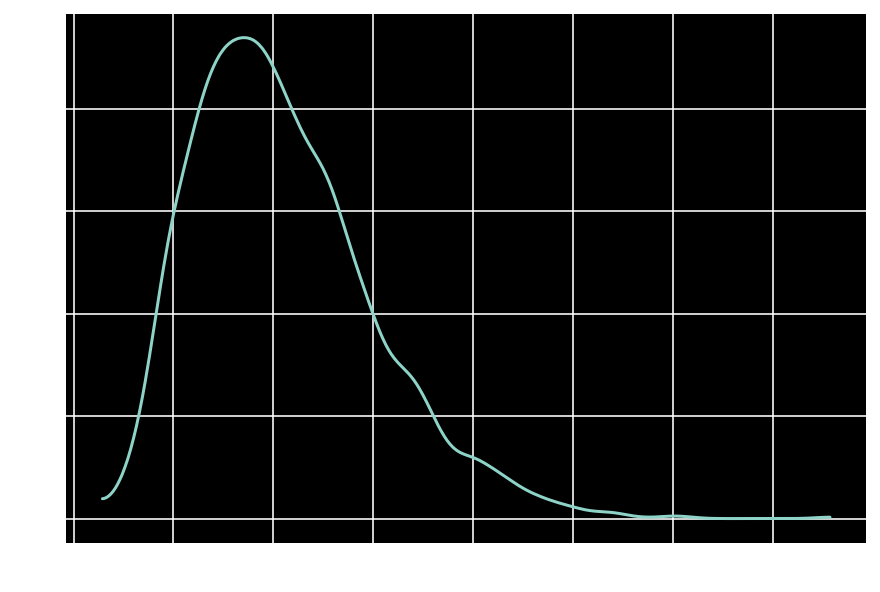

In [235]:
post = trace1.posterior
az.plot_kde(post['chol_corr'][:,:,1,0].values)

In [286]:
obsMeans = d.groupby(['afternoon','cafe']).mean()
obsMeans

wait
afternoon cafe          
0         0     2.598605
          1     2.908544
          2     3.198849
          3     4.580117
          4     3.930953
          5     2.872221
          6     2.587595
          7     3.446143
          8     4.998008
          9     3.428156
          10    1.575921
          11    3.226107
          12    4.414619
          13    3.345164
          14    4.045631
          15    2.683288
          16    3.947998
          17    3.753630
          18    3.431325
          19    3.332568
1         0     1.684112
          1     2.479917
          2     2.449693
          3     2.940450
          4     2.503273
          5     2.422821
          6     2.588040
          7     1.542413
          8     3.531405
          9     1.392908
          10    1.276596
          11    2.309680
          12    2.953163
          13    1.821998
          14    2.364159
          15    2.415876
          16    2.627842
          17    2.198607
          18    1.714558
          19    2.277256

In [294]:
estMeans = post['ab'].mean(['chain','draw'])
estMeans

<xarray.DataArray 'ab' (ab_dim_0: 20, ab_dim_1: 2)>
array([[ 2.65414313, -0.9367262 ],
       [ 3.01366452, -0.64690762],
       [ 3.25821892, -0.87888045],
       [ 4.47991683, -1.544204  ],
       [ 3.87393667, -1.35590385],
       [ 2.97632159, -0.65443212],
       [ 2.76029966, -0.35384249],
       [ 3.34571412, -1.63053412],
       [ 4.90441081, -1.45999046],
       [ 3.31175052, -1.70735106],
       [ 1.73926511, -0.46480979],
       [ 3.25815061, -0.98186661],
       [ 4.34108897, -1.41495273],
       [ 3.2973953 , -1.37748344],
       [ 3.95301371, -1.52707011],
       [ 2.81572075, -0.53095057],
       [ 3.90730045, -1.29426685],
       [ 3.68493135, -1.42592636],
       [ 3.35634609, -1.50580702],
       [ 3.34776385, -1.08009509]])
Coordinates:
  * ab_dim_0  (ab_dim_0) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19
  * ab_dim_1  (ab_dim_1) int64 0 1

In [351]:
obsA = obsMeans.loc[0,'wait'].values  # morning
obsB = obsMeans.loc[1,'wait'].values - obsA  # afternoon - morning
estA = estMeans[:,0].values # intercepts
estB = estMeans[:,1].values # slopes
obsMorning = obsA
obsAfternoon = obsA + obsB
estMorning = estA
estAfternoon = estA + estB

estMu = post['mu_ab'].mean(['chain','draw']).values
estSvec = post['chol_stds'].mean(['chain','draw']).values
estRho = post['chol_corr'].mean(['chain','draw']).values
estSigma = np.diag(estSvec) @ estRho @ np.diag(estSvec)
x0 = np.random.multivariate_normal(estMu, estSigma, 100000)

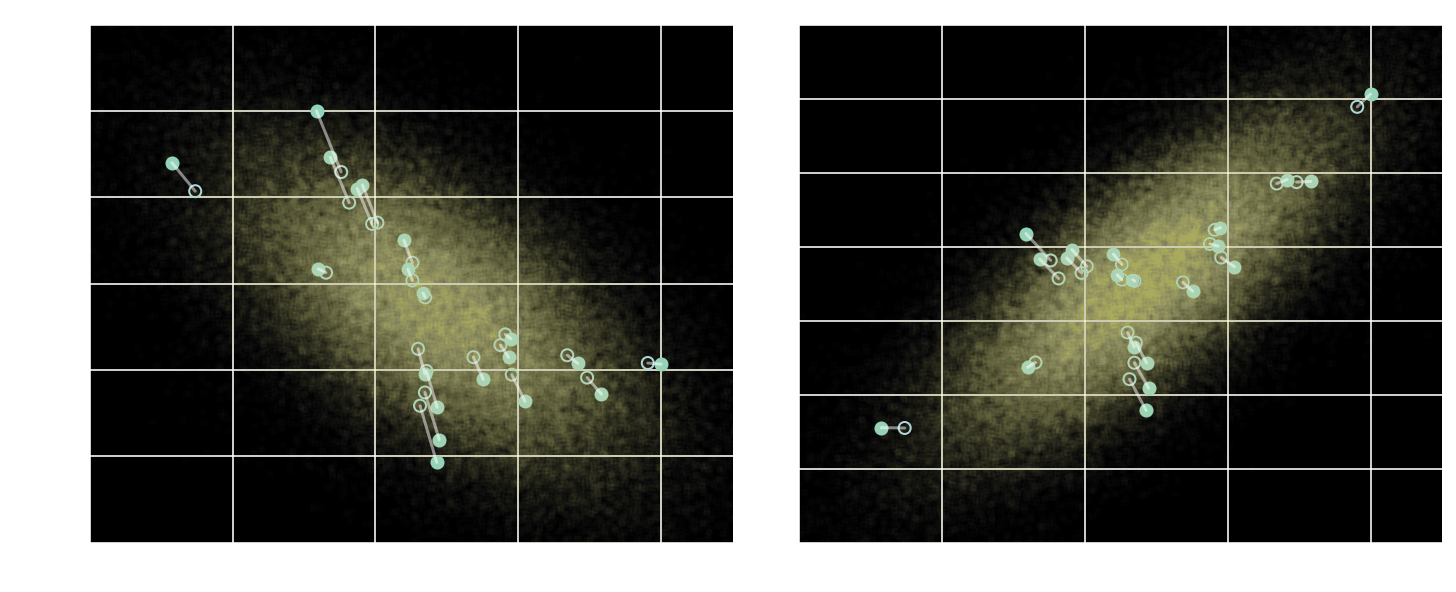

In [357]:
_, (ax,ax2) = plt.subplots(1,2,figsize=[10,4])
ax.set_xlim(1.0,5.5)
ax.set_ylim(-2.5,0.5)
ax.scatter(obsA, obsB)
ax.scatter(estA, estB, facecolors="none", edgecolors="lightblue", lw=1, alpha=1.0)
ax.plot([obsA, estA], [obsB, estB], "w-", alpha=0.5);
ax.scatter(x0[:,0], x0[:,1], marker='.', alpha=0.01);

ax2.set_xlim(1,5.5)
ax2.set_ylim(0.5,4.0)
ax2.scatter(obsMorning, obsAfternoon)
ax2.scatter(estMorning, estAfternoon, facecolors="none", edgecolors="lightblue", lw=1, alpha=1.0)
ax2.plot([obsMorning, estMorning], [obsAfternoon, estAfternoon], "w-", alpha=0.5);
ax2.scatter(x0[:,0], x0[:,0] + x0[:,1], marker='.', alpha=0.01);
